In [1]:
%pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.2 MB/s eta 0:00:00a 0:00:010m

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import igraph as ig
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import girvan_newman
from itertools import islice
from dotenv import load_dotenv
import os


load_dotenv()

True

In [3]:
flickr_dataset_path = os.environ.get("FLICKR_DATASET")
edges_df = pd.read_csv(flickr_dataset_path + "edges_sampled_15K.csv", header=None, names=["source", "target"])

my_graph = nx.Graph()
my_graph.add_edges_from(edges_df.values)

In [4]:
def girvan_newman_algo(graph, num_communities=5):
    comp = girvan_newman(graph)
    limited = next(islice(comp, num_communities - 1, None))
    return [list(c) for c in limited]


communities = girvan_newman_algo(my_graph, num_communities=5)

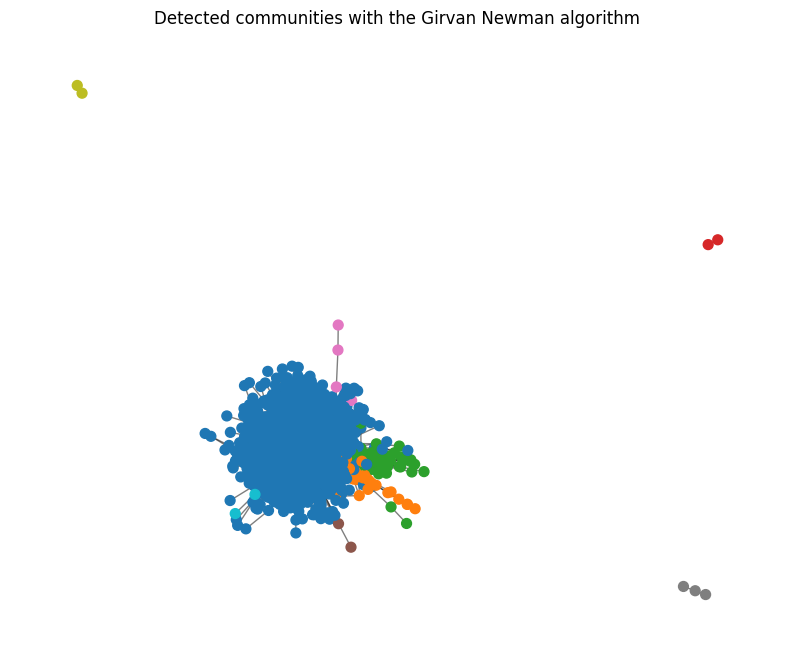

In [6]:
def visualize_communities(gr, comms):
    color_map = {}
    for i, community in enumerate(comms):
        for node in community:
            color_map[node] = i
    node_colors = [color_map.get(node, 0) for node in gr.nodes()]

    position = nx.spring_layout(gr, seed=97)
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(gr, position, node_color=node_colors, cmap=plt.cm.tab10, node_size=50)
    nx.draw_networkx_edges(gr, position, alpha=0.5)
    plt.title("Detected communities with the Girvan Newman algorithm")
    plt.axis("off")
    plt.show()

visualize_communities(my_graph, communities)

In [7]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

In [8]:
membership_df = pd.read_csv(flickr_dataset_path + "community_membership_15K.csv", header=None)
membership_df.columns = ["node", "community"]

In [9]:
ground_truth = membership_df.set_index('node')['community'].to_dict()

In [10]:
def convert_communities_to_labels(graph, communities):
    node_to_comm = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_comm[node] = i
    valid_nodes = list(set(graph.nodes()).intersection(set(ground_truth.keys())))
    detected_labels = [node_to_comm[n] for n in valid_nodes]
    true_labels = [ground_truth[n] for n in valid_nodes]
    return true_labels, detected_labels


expected, actual = convert_communities_to_labels(my_graph, communities)

In [11]:
nmi = normalized_mutual_info_score(expected, actual)
ari = adjusted_rand_score(expected, actual)

print("NMI ", nmi)
print("ARI ", ari)

NMI  0.05117975702443277
ARI  0.044583196681295734
